In [7]:
import numpy as np
import os
import sys 
import pandas as pd
import matplotlib.pyplot as plt

# Append paths to utility libraries 
sys.path.append('/Users/zacharykelly/Documents/MATLAB/projects/combiExperiments/code/lightLogger/miniSpect')
import MS_util 

sys.path.append('/Users/zacharykelly/Documents/MATLAB/projects/combiExperiments/code/lightLogger/camera')
import Camera_util
import recorder as r_world


In [15]:
# Define the path to the SSD holding all of the data
path_to_ssd: str = '/Volumes/EXTERNAL1'

In [16]:
# Experiment to analyze 
experiment_name: str = 'together_15min_0x5hz'
frequency = 5 
NDF = 1 

In [14]:
# Find the MS readings directory
MS_readings_dir: str = os.path.join(path_to_ssd, experiment_name, 'together_15min_MS_readings')

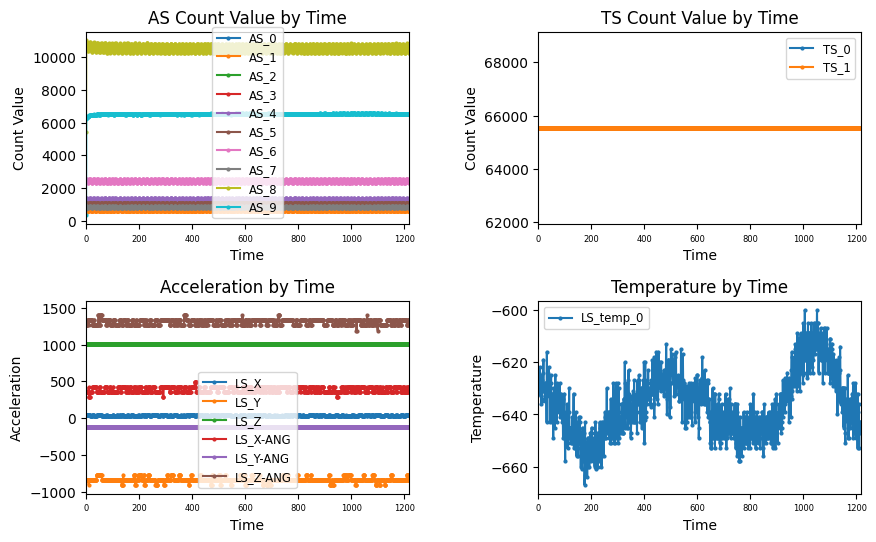

In [28]:
# Analyze the MS data
MS_util.plot_readings(MS_readings_dir)


In [17]:
# Find the world cam frame dir and the settings file
world_cam_dir: str = os.path.join(path_to_ssd, experiment_name, 'together_15min_world')
world_cam_settings_file: str = os.path.join(path_to_ssd, experiment_name, 'together_15min_world_settingsHistory.csv')

In [11]:
import importlib
importlib.reload(Camera_util)
# Load in the world cam video 
world_cam_vid: np.ndarray = Camera_util.parse_mean_frame_array(world_cam_dir)


Observed FPS: 120.1112702062034
R2: 0.9011879742911563
Amplitude: 0.4262513799809726


(0.4262513799809726,
 -0.6391924361899323,
 120.1112702062034,
 (array([0.00000000e+00, 8.32561339e-03, 1.66512268e-02, ...,
         1.23383925e+03, 1.23384758e+03, 1.23385590e+03]),
  array([-0.84703429, -0.84703429, -0.85508511, ..., -0.4042388 ,
         -0.35593384, -0.2834764 ]),
  array([0.0000000e+00, 1.0000000e-04, 2.0000000e-04, ..., 1.2338639e+03,
         1.2338640e+03, 1.2338641e+03]),
  array([-0.2542792 , -0.25535268, -0.25642364, ..., -0.20245383,
         -0.20127441, -0.20009301])))

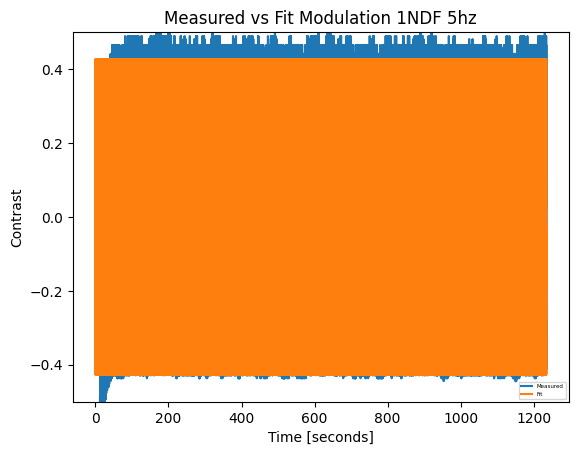

In [12]:
# Fit the world cam source modulation
fig, ax = plt.subplots(1,1)

Camera_util.fit_source_modulation(world_cam_vid, NDF, frequency, ax)

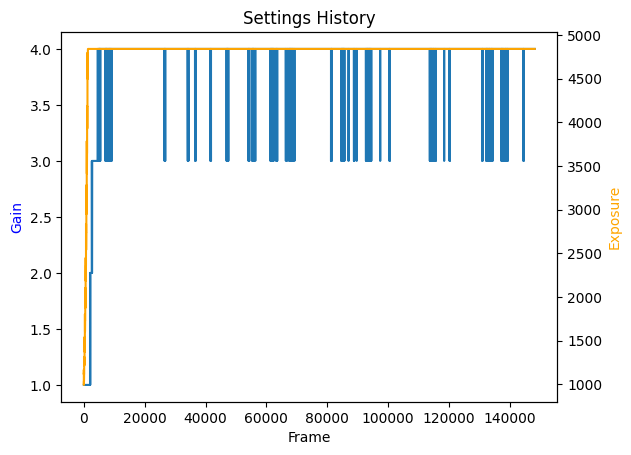

In [18]:
# Plot the camera settings history
world_cam_settings: pd.DataFrame = r_world.parse_settings_file(world_cam_settings_file)
world_cam_settings.head

fig, gain_ax = plt.subplots(1,1)
gain_ax.set_title('Settings History')

gain_ax.plot(world_cam_settings['gain_history'])
gain_ax.set_xlabel('Frame')
gain_ax.set_ylabel('Gain', color='blue')

exposure_ax = gain_ax.twinx()
exposure_ax.plot(world_cam_settings['exposure_history'], color='orange')
exposure_ax.set_ylabel('Exposure', color='orange')

plt.show()



In [19]:
# Find the pupil cam frame directory
pupil_cam_dir: str = os.path.join(path_to_ssd, experiment_name, 'together_15min_pupil')

In [20]:
import importlib
importlib.reload(Camera_util)
# Load in the pupil cam video 
pupil_vid: np.ndarray = Camera_util.parse_mean_frame_array(pupil_cam_dir)


Observed FPS: 30.1088573103354
R2: 3.976602151524437e-06
Amplitude: 7.69519843238684e-05


(7.69519843238684e-05,
 1.4827483295921362,
 30.1088573103354,
 (array([0.00000000e+00, 3.32128181e-02, 6.64256361e-02, ...,
         1.30815327e+03, 1.30818648e+03, 1.30821969e+03]),
  array([-4.48144451e-02, -1.00000000e+00, -1.00000000e+00, ...,
          6.81720655e-03,  3.63250100e-04,  3.63250100e-04]),
  array([0.0000000e+00, 1.0000000e-04, 2.0000000e-04, ..., 1.3082526e+03,
         1.3082527e+03, 1.3082528e+03]),
  array([ 7.66538938e-05,  7.66322573e-05,  7.66098644e-05, ...,
         -1.29983944e-05, -1.32366078e-05, -1.34746906e-05])))

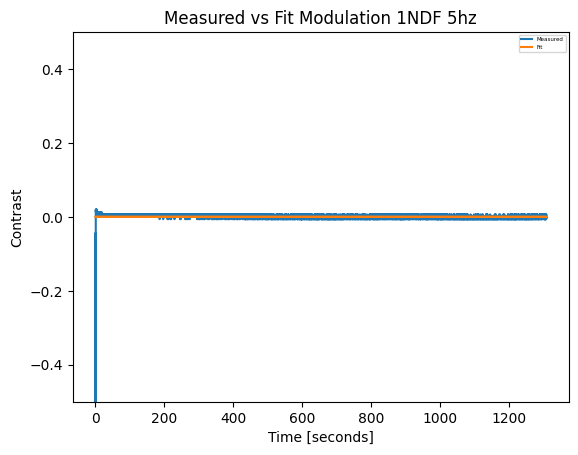

In [29]:
# Fit the pupil cam source modulation
fig, ax = plt.subplots(1,1)

Camera_util.fit_source_modulation(pupil_vid, NDF, frequency, ax, fps_guess=30)

In [23]:
# Find the sunglasses reading file 
sunglasses_file: str = os.path.join(path_to_ssd, experiment_name, 'together_15min_sunglasses.csv')

In [26]:
# Load in the sunglasses file 
sunglasses_df: pd.DataFrame = pd.read_csv(sunglasses_file, header=None, names=['sensor_val'])
sunglasses_df.head

<bound method NDFrame.head of      sensor_val
0          1641
1          1644
2          1648
3          1644
4          1642
..          ...
118        1645
119        1643
120        1641
121        1643
122        1646

[123 rows x 1 columns]>

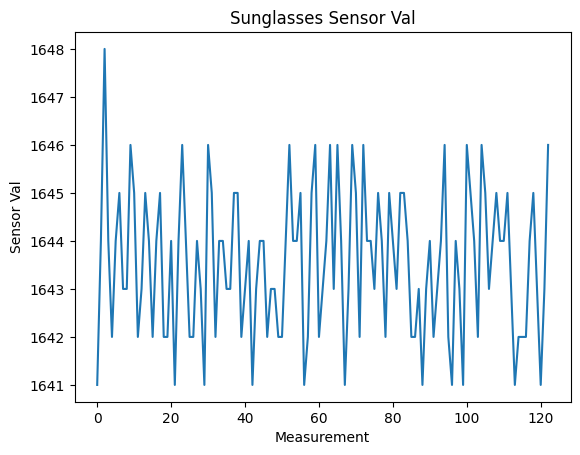

In [27]:
fig, ax = plt.subplots(1,1)

ax.set_title('Sunglasses Sensor Val')
ax.plot(sunglasses_df['sensor_val'])
ax.set_xlabel('Measurement')
ax.set_ylabel('Sensor Val')

plt.show()